In [6]:
%reload_ext autoreload
%autoreload 2

### 1. Split data into train, test

In [38]:
from datasets.german_credit import GermanCreditDataset
dataset = GermanCreditDataset()
X_train, y_train, X_test, _ = dataset.get_original_train_test_split()

[INFO] Dropped rows with NaN: 478 (kept 522)


Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


### 2. Build the pipeline and train the model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Define feature lists
numerical_features = ['Age', 'Credit amount', 'Duration']
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Step 1: Create the preprocessor
# Linear models require feature scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Step 2: Create the Logistic Regression classifier
lr_clf = LogisticRegression(
    max_iter=1000,
    C=1.0,  # Inverse of regularization strength
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    solver='lbfgs'  # Suitable for small datasets
)

# Step 3: Create the Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lr_clf)
])

# Step 4: Training
# Ensure categorical features are strings before fitting, as OneHotEncoder expects string-like input often
for c in categorical_features:
    X_train[c] = X_train[c].astype(str)
    X_test[c] = X_test[c].astype(str)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'Credit amount',
                                                   'Duration']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Sex', 'Job', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

### 3. Pick instances(whose predictions are 1)

In [49]:
import pandas as pd

# === Config ===
TARGET_COLUMN_NAME = "Risk"   # name of the prediction column
N = 10                                   # number of rows to sample; set to None to return all
RANDOM_STATE = 42

# 1) 预测
X_df = X_test.copy() if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test)
preds = pd.Series(pipe.predict(X_test), index=X_df.index, name=TARGET_COLUMN_NAME)

# 2) 覆盖而非追加（避免重复列）
X_df = X_df.drop(columns=[TARGET_COLUMN_NAME], errors="ignore")
X_df[TARGET_COLUMN_NAME] = preds.values
X_test = X_df  # 覆盖变量

# 3) 筛选预测为 1，并可选抽样
df = X_test.loc[X_test[TARGET_COLUMN_NAME] == 1]
if N is not None and len(df) > N:
    df = df.sample(n=N, random_state=RANDOM_STATE)


# Optional: inspect
# display(X_test.head())
df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
245,26,female,skilled,rent,little,little,3114,18,furniture/equipment,1
472,32,female,highly skilled,own,little,moderate,18424,48,vacation/others,1
152,48,male,skilled,own,little,little,1024,24,radio/TV,1
176,24,female,highly skilled,own,moderate,moderate,7408,60,car,1
483,24,male,unskilled and resident,own,little,little,1747,24,furniture/equipment,1


-----------------------

### **1**. Initialize data interface (COLAData)

In [ ]:
from xai_cola.ce_sparsifier.data import COLAData

numerical_features = ['Age', 'Credit amount', 'Duration']
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
data = COLAData(
    factual_data=df, 
    label_column='Risk',
    numerical_features=numerical_features
)
print(data)

COLAData(factual: 10 rows, features: 9, label: Risk, no counterfactual)


### **2**. Initialize model interface (Model)

In [ ]:
from xai_cola.ce_sparsifier.models import Model

ml_model = Model(model=pipe, backend="sklearn")

### **3.** Choose the counterfactual generator & generate counterfactuals

In [ ]:
from xai_cola.ce_generator import DiCE

explainer = DiCE(ml_model=ml_model)
factual, counterfactual = explainer.generate_counterfactuals(
    data=data,
    factual_class=1, # class of target column of the factual instances
    total_cfs=2, # number of counterfactuals to generate per factual instance
    features_to_keep=['Age','Sex'],
    continuous_features=numerical_features
)
display(counterfactual)


# Add counterfactual data to COLAData object first
data.add_counterfactuals(counterfactual, with_target_column=True)
data.summary()

100%|██████████| 10/10 [00:00<00:00, 10.76it/s]


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,26,female,skilled,rent,little,little,10040,18,furniture/equipment,0
1,26,female,highly skilled,rent,little,little,13401,18,furniture/equipment,0
2,32,female,highly skilled,own,little,moderate,18424,36,vacation/others,0
3,32,female,highly skilled,own,little,moderate,5787,32,vacation/others,0
4,48,male,skilled,own,little,little,13133,24,radio/TV,0
5,48,male,skilled,own,little,little,7071,18,radio/TV,0
6,24,female,highly skilled,own,little,moderate,7408,22,car,0
7,24,female,highly skilled,own,little,moderate,7408,24,car,0
8,24,male,unskilled and resident,own,little,little,12322,24,furniture/equipment,0
9,24,male,unskilled and resident,own,little,little,17806,24,furniture/equipment,0


{'factual_samples': 10,
 'feature_count': 9,
 'label_column': 'Risk',
 'all_columns': ['Age',
  'Sex',
  'Job',
  'Housing',
  'Saving accounts',
  'Checking account',
  'Credit amount',
  'Duration',
  'Purpose',
  'Risk'],
 'has_counterfactual': True,
 'has_transform_method': False,
 'has_transformed_data': False,
 'counterfactual_samples': 20}

### **4.** Initialize COLA & set policy

In [ ]:
from xai_cola.ce_sparsifier import COLA

# Initialize COLA - it will automatically extract factual and counterfactual from data
sparsifier = COLA(
    data=data,
    ml_model=ml_model
)

sparsifier.set_policy(
    matcher="nn", # optimal transport matcher
    attributor="pshap", # SHAP attributor
    random_state=1 # Set random seed for reproducibility
)

Policy set: pshap with Nearest Neighbor Matching.


### **5.** Refine counterfactuals with COLA

In [80]:
# Query minimum actions
limited_actions = sparsifier.query_minimum_actions()

The minimum number of actions is 24


In [81]:
# Get (refined counterfactuals) with limited actions
refined_cf_df = sparsifier.get_refined_counterfactual(limited_actions=limited_actions)
display(refined_cf_df)

# Get (factual, counterfactual, refined counterfactuals) with limited actions
# factual_df, counterfactual_df, refined_cf_df = sparsifier.get_all_results(
#     limited_actions=limited_actions,
#     # features_to_vary=['Saving accounts','Checking account','Credit amount','Duration','Purpose']
# )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 2
INFO:shap:phi = [-0.04484088 -0.07113471 -0.0158834   0.07541369]
INFO:shap:phi = [ 0.04484088  0.07113471  0.0158834  -0.07541369]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 2
INFO:shap:phi = [-0.01657392 -0.01936624  0.02008199 -0.31709044 -0.08037885]
INFO:shap:phi = [ 0.01657392  0.01936624 -0.02008199  0.31709044  0.08037885]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 2
INFO:shap:phi = [ 0.00297277 -0.05519583 -0.03187983 -0.04402183]
INFO:shap:phi = [-0.00297277  0.05519583  0.03187983  0.04402183]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 3
INFO:shap:phi = [-0.01433759 -0.05926473 -0.06859853 -0.05321718 -0.01975561  0.05930045
 -0.02333004]
INFO:shap:phi = [ 0.01433759  0.05926473  0.06859853  0.05321718  0.01975561 -0.05930045
  0.02333004]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.00335354 -0.21265322]
INFO:shap:phi = [0.00335354 0.21265322]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.07148172  0.01836187]
INFO:shap:phi = [ 0.07148172 -0.01836187]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.0404168  -0.11383976]
INFO:shap:phi = [0.0404168  0.11383976]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.02993908 -0.36515032]
INFO:shap:phi = [-0.02993908  0.36515032]


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
245,26,female,skilled,rent,little,little,10040,18,furniture/equipment,0
472,32,female,highly skilled,own,little,moderate,18424,36,vacation/others,0
152,63,male,highly skilled,own,little,little,1024,24,car,0
176,32,female,highly skilled,own,moderate,moderate,7408,32,vacation/others,0
483,24,male,unskilled and resident,own,little,moderate,3522,24,vacation/others,0
411,30,male,highly skilled,own,little,moderate,3509,22,radio/TV,0
103,30,male,highly skilled,own,little,moderate,4652,22,business,0
239,63,male,highly skilled,own,little,little,1907,24,car,0
192,23,male,unskilled and resident,own,little,moderate,3522,24,vacation/others,0
441,29,male,skilled,rent,little,little,9869,20,business,0


#### **6.** Visualization

##### 6.1 Highlight the changes between factual and counterfactual

In [82]:
factual, ce, refine_ce = sparsifier.highlight_changes_comparison()
display(factual, ce, refine_ce) # display the highlighted dataframes
# refine_ce.to_html('comparison.html')  # save to html file

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
245,26,female,skilled,rent,little,little,3114,18,furniture/equipment,1
472,32,female,highly skilled,own,little,moderate,18424,48,vacation/others,1
152,48,male,skilled,own,little,little,1024,24,radio/TV,1
176,24,female,highly skilled,own,moderate,moderate,7408,60,car,1
483,24,male,unskilled and resident,own,little,little,1747,24,furniture/equipment,1
411,25,female,skilled,own,little,little,3509,18,radio/TV,1
103,30,male,highly skilled,own,little,moderate,4455,36,business,1
239,63,male,skilled,own,little,little,2924,24,car,1
192,23,male,unskilled and resident,own,little,moderate,1246,24,car,1
441,29,male,skilled,rent,little,little,11816,45,business,1


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
245,26,female,skilled,rent,little,little,3114 -> 10040,18,furniture/equipment,1 -> 0
472,32,female,highly skilled,own,little,moderate,18424,48 -> 36,vacation/others,1 -> 0
152,48 -> 63,male,skilled -> highly skilled,own,little,little,1024 -> 1907,24,radio/TV -> car,1 -> 0
176,24 -> 32,female,highly skilled,own,moderate -> little,moderate,7408 -> 5787,60 -> 32,car -> vacation/others,1 -> 0
483,24 -> 23,male,unskilled and resident,own,little,little -> moderate,1747 -> 3522,24,furniture/equipment -> vacation/others,1 -> 0
411,25 -> 30,female -> male,skilled -> highly skilled,own,little,little -> moderate,3509 -> 4652,18 -> 22,radio/TV -> business,1 -> 0
103,30,male,highly skilled,own,little,moderate,4455 -> 4652,36 -> 22,business,1 -> 0
239,63,male,skilled -> highly skilled,own,little,little,2924 -> 1907,24,car,1 -> 0
192,23,male,unskilled and resident,own,little,moderate,1246 -> 3522,24,car -> vacation/others,1 -> 0
441,29,male,skilled,rent,little,little,11816 -> 9869,45 -> 20,business,1 -> 0


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
245,26,female,skilled,rent,little,little,3114 -> 10040,18,furniture/equipment,1 -> 0
472,32,female,highly skilled,own,little,moderate,18424,48 -> 36,vacation/others,1 -> 0
152,48 -> 63,male,skilled -> highly skilled,own,little,little,1024,24,radio/TV -> car,1 -> 0
176,24 -> 32,female,highly skilled,own,moderate,moderate,7408,60 -> 32,car -> vacation/others,1 -> 0
483,24,male,unskilled and resident,own,little,little -> moderate,1747 -> 3522,24,furniture/equipment -> vacation/others,1 -> 0
411,25 -> 30,female -> male,skilled -> highly skilled,own,little,little -> moderate,3509,18 -> 22,radio/TV,1 -> 0
103,30,male,highly skilled,own,little,moderate,4455 -> 4652,36 -> 22,business,1 -> 0
239,63,male,skilled -> highly skilled,own,little,little,2924 -> 1907,24,car,1 -> 0
192,23,male,unskilled and resident,own,little,moderate,1246 -> 3522,24,car -> vacation/others,1 -> 0
441,29,male,skilled,rent,little,little,11816 -> 9869,45 -> 20,business,1 -> 0


##### 6.2 Highlight the changed positions in counterfactuals and refined counterfactuals

In [ ]:
factual_df, ce_style, ace_style = sparsifier.highlight_changes_final()
display(ce_style, ace_style)  # display the highlighted dataframes
# ce_style.to_html('final.html') # save to html file

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
245,26,female,skilled,rent,little,little,10040,18,furniture/equipment,0
472,32,female,highly skilled,own,little,moderate,18424,36,vacation/others,0
152,63,male,highly skilled,own,little,little,1907,24,car,0
176,32,female,highly skilled,own,little,moderate,5787,32,vacation/others,0
483,23,male,unskilled and resident,own,little,moderate,3522,24,vacation/others,0
411,30,male,highly skilled,own,little,moderate,4652,22,business,0
103,30,male,highly skilled,own,little,moderate,4652,22,business,0
239,63,male,highly skilled,own,little,little,1907,24,car,0
192,23,male,unskilled and resident,own,little,moderate,3522,24,vacation/others,0
441,29,male,skilled,rent,little,little,9869,20,business,0


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
245,26,female,skilled,rent,little,little,10040,18,furniture/equipment,0
472,32,female,highly skilled,own,little,moderate,18424,36,vacation/others,0
152,63,male,highly skilled,own,little,little,1024,24,car,0
176,32,female,highly skilled,own,moderate,moderate,7408,32,vacation/others,0
483,24,male,unskilled and resident,own,little,moderate,3522,24,vacation/others,0
411,30,male,highly skilled,own,little,moderate,3509,22,radio/TV,0
103,30,male,highly skilled,own,little,moderate,4652,22,business,0
239,63,male,highly skilled,own,little,little,1907,24,car,0
192,23,male,unskilled and resident,own,little,moderate,3522,24,vacation/others,0
441,29,male,skilled,rent,little,little,9869,20,business,0


##### 6.3 Heatmap of Changes: Factuals vs. Counterfactuals / Refined Counterfactuals

In [84]:
sparsifier.heatmap_binary(save_path='./results', save_mode='combined',show_axis_labels=False)


Binary changes from factual to counterfactual:
Binary changes from factual to action-limited counterfactual:
✅ Combined heatmap saved to: ./results\combined_heatmap.png


(<Figure size 1000x600 with 1 Axes>, <Figure size 1000x600 with 1 Axes>)

##### 6.4 Heatmap of Change Direction(increase or decrease): Factuals vs. Counterfactuals / Refined Counterfactuals

In [ ]:
sparsifier.heatmap_direction(save_path='./results', save_mode='combined',show_axis_labels=False)

Directional changes from factual to counterfactual:
Directional changes from factual to action-limited counterfactual:
✅ Combined directional heatmap saved to: ./results\combined_direction_heatmap.png


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


(<Figure size 1000x600 with 1 Axes>, <Figure size 1000x600 with 1 Axes>)

##### 6.5 Actions Required to Flip the Target per Instance: Refined Counterfactuals vs. Original Counterfactuals

✅ Stacked bar chart saved to: ./results\stacked_bar_chart.png


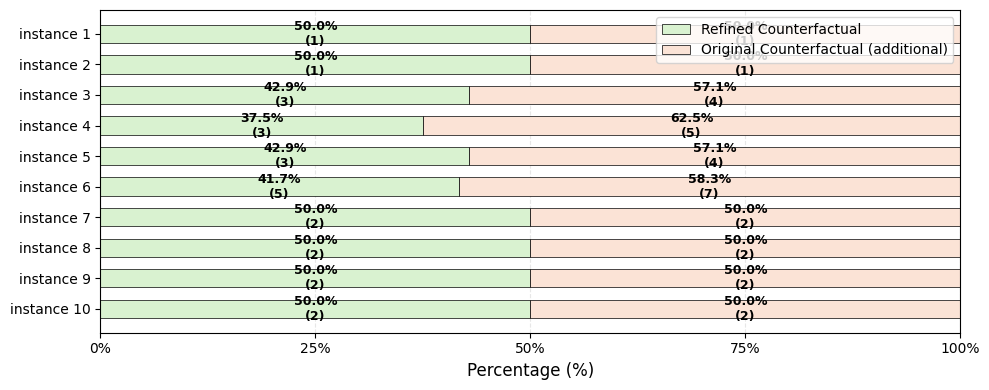

In [76]:
fig = sparsifier.stacked_bar_chart(save_path='./results')

##### 6.6 Diversity results via exhaustive search on refined counterfactuals

In [86]:
factual_df, diversity_styles = sparsifier.diversity()
for i, style in enumerate(diversity_styles):
    print(f"Instance {i+1} diversity:")
    display(style)

Instance 1 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,26,female,skilled,rent,little,little,10040,18,furniture/equipment,0


Instance 2 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,32,female,highly skilled,own,little,moderate,18424,36,vacation/others,0


Instance 3 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,63,male,highly skilled,own,little,little,1024,24,car,0
1,63,male,skilled,own,little,little,1024,24,radio/TV,0
2,48,male,highly skilled,own,little,little,1024,24,radio/TV,0


Instance 4 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,32,female,highly skilled,own,moderate,moderate,7408,32,vacation/others,0


Instance 5 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,24,male,unskilled and resident,own,little,moderate,3522,24,vacation/others,0
1,24,male,unskilled and resident,own,little,moderate,1747,24,vacation/others,0


Instance 6 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,30,male,highly skilled,own,little,moderate,3509,22,radio/TV,0
1,30,female,skilled,own,little,little,3509,18,radio/TV,0
2,25,male,skilled,own,little,little,3509,18,radio/TV,0
3,25,female,highly skilled,own,little,little,3509,18,radio/TV,0
4,25,female,skilled,own,little,moderate,3509,18,radio/TV,0


Instance 7 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,30,male,highly skilled,own,little,moderate,4652,22,business,0
1,30,male,highly skilled,own,little,moderate,4455,22,business,0


Instance 8 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,63,male,highly skilled,own,little,little,1907,24,car,0
1,63,male,highly skilled,own,little,little,2924,24,car,0


Instance 9 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,23,male,unskilled and resident,own,little,moderate,3522,24,vacation/others,0


Instance 10 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,29,male,skilled,rent,little,little,9869,20,business,0
1,29,male,skilled,rent,little,little,11816,20,business,0
